In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


In [19]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [3]:
warnings.filterwarnings("ignore")


In [13]:
nlp = spacy.load('en_core_web_sm')

In [7]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
df_newsgroups = pd.DataFrame({
    'Category': newsgroups.target,
    'Text': newsgroups.data    
})

df_newsgroups.head()

,Category,Text
0,10,\n\nI am sure some bashers of Pens fans are pr...
1,3,My brother is in the market for a high-perform...
2,17,\n\n\n\n\tFinally you said what you dream abou...
3,3,\nThink!\n\nIt's the SCSI card doing the DMA t...
4,4,1) I have an old Jasmine drive which I cann...


## Data Preprocessing

In [9]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = text.lower()

    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

    return text

In [11]:
df_newsgroups['cleaned_text'] = df_newsgroups['Text'].apply(clean_text)

In [15]:
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

df_newsgroups['lemmatized_text'] = df_newsgroups['cleaned_text'].apply(lemmatize_text)

print(df_newsgroups[['cleaned_text', 'lemmatized_text']].head())

                                        cleaned_text  \
0  sure bashers pens fans pretty confused lack ki...   
1  brother market highperformance video card supp...   
2  finally said dream mediterranean new area grea...   
3  think scsi card doing dma transfers disks scsi...   
4  old jasmine drive use new understanding upsate...   

                                     lemmatized_text  
0  sure basher pen fan pretty confused lack kind ...  
1  brother market highperformance video card supp...  
2  finally say dream mediterranean new area great...  
3  think scsi card dma transfer disk scsi card dm...  
4  old jasmine drive use new understanding upsate...  


In [17]:
df_newsgroups

,Category,Text,cleaned_text,lemmatized_text
0,10,\n\nI am sure some bashers of Pens fans are pr...,sure bashers pens fans pretty confused lack ki...,sure basher pen fan pretty confused lack kind ...
1,3,My brother is in the market for a high-perform...,brother market highperformance video card supp...,brother market highperformance video card supp...
2,17,\n\n\n\n\tFinally you said what you dream abou...,finally said dream mediterranean new area grea...,finally say dream mediterranean new area great...
3,3,\nThink!\n\nIt's the SCSI card doing the DMA t...,think scsi card doing dma transfers disks scsi...,think scsi card dma transfer disk scsi card dm...
4,4,1) I have an old Jasmine drive which I cann...,old jasmine drive use new understanding upsate...,old jasmine drive use new understanding upsate...
...,...,...,...,...
18841,13,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,dn nyedacnsvaxuwecedu david nye dn neurology d...,dn nyedacnsvaxuwecedu david nye dn neurology d...
18842,12,\nNot in isolated ground recepticles (usually ...,isolated ground recepticles usually unusual co...,isolate ground recepticle usually unusual colo...
18843,3,I just installed a DX2-66 CPU in a clone mothe...,just installed dx cpu clone motherboard tried ...,instal dx cpu clone motherboard try mount cpu ...
18844,1,\nWouldn't this require a hyper-sphere. In 3-...,wouldnt require hypersphere space points speci...,not require hypersphere space point specifie s...


## Implementing Word2Vec

In [21]:
df_newsgroups['tokenized_text'] = df_newsgroups['lemmatized_text'].apply(word_tokenize)

In [23]:
print(df_newsgroups[['lemmatized_text', 'tokenized_text']].head())

                                     lemmatized_text  \
0  sure basher pen fan pretty confused lack kind ...   
1  brother market highperformance video card supp...   
2  finally say dream mediterranean new area great...   
3  think scsi card dma transfer disk scsi card dm...   
4  old jasmine drive use new understanding upsate...   

                                      tokenized_text  
0  [sure, basher, pen, fan, pretty, confused, lac...  
1  [brother, market, highperformance, video, card...  
2  [finally, say, dream, mediterranean, new, area...  
3  [think, scsi, card, dma, transfer, disk, scsi,...  
4  [old, jasmine, drive, use, new, understanding,...  


In [25]:
tokenized_corpus = df_newsgroups['tokenized_text'].tolist()

In [27]:
word2vec_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,  
    window=7,         
    min_count=2,     
    sg=1,             
    workers=4,        
    epochs=15,        
    negative=5        
)

In [31]:
example_vector = word2vec_model.wv['example']
example_vector

array([-0.3628456 , -0.01796141,  0.38234073,  0.14687382,  0.09169935,
        0.00779224, -0.3508467 ,  0.34696865,  0.02908266, -0.01883128,
        0.45185366, -0.2733189 ,  0.18089883,  0.04395417, -0.22003476,
       -0.38552958, -0.17148079,  0.01111998, -0.22622588, -0.49584383,
       -0.14950617,  0.23171411,  0.13564906,  0.20849448, -0.09669879,
        0.06030422,  0.10865565,  0.0312739 , -0.22111821,  0.22226429,
        0.06974188, -0.07136529, -0.01045551, -0.48826924,  0.05174782,
        0.14503899,  0.3503733 , -0.15649039, -0.00623139, -0.23359975,
        0.2990166 , -0.12452695, -0.0139723 ,  0.03751213,  0.35446075,
       -0.4852892 ,  0.08340874,  0.04595486,  0.09617549,  0.13342775,
        0.45401037, -0.18125238, -0.08532505,  0.32491162, -0.37385458,
        0.14427903,  0.48534295,  0.17384015,  0.06783806, -0.5055389 ,
        0.22742094,  0.02461065,  0.19758554, -0.38678634, -0.11244118,
        0.25492504,  0.13825628,  0.22177635, -0.32256126, -0.11

In [33]:
def document_embedding(tokenized_text, model):
    embeddings = [model.wv[word] for word in tokenized_text if word in model.wv]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)

In [35]:
df_newsgroups['doc_embedding'] = df_newsgroups['tokenized_text'].apply(lambda x: document_embedding(x, word2vec_model))

In [37]:
print(df_newsgroups[['Category', 'doc_embedding']].head())

   Category                                      doc_embedding
0        10  [-0.18359414, 0.39904758, 0.15155232, -0.00854...
1         3  [-0.5865672, 0.04830786, -0.12760575, -0.01073...
2        17  [-0.058039468, 0.3535628, 0.13834186, 0.166795...
3         3  [-0.31932127, 0.14305022, 0.23791373, -0.02077...
4         4  [-0.27733502, 0.1666114, 0.05771007, 0.0299441...


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [41]:
X = np.vstack(df_newsgroups['doc_embedding'])
y = df_newsgroups['Category']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
accuracy = clf.score(X_test, y_test)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.6628647214854111


In [53]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
0.6908329819268163


In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [71]:
from xgboost import XGBClassifier  
estimators = [
    ('rf', RandomForestClassifier(**grid_search.best_params_)),  
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')) 
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train_scaled, y_train)  
print(clf.score(X_test_scaled, y_test)) 

0.6928381962864721


In [73]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3)
gbm.fit(X_train_scaled, y_train)
print(f"Test Accuracy: {gbm.score(X_test_scaled, y_test)}")


Test Accuracy: 0.6663129973474801


In [77]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],  
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 0.1, 0.01, 0.001]  
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)  

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_svm = grid_search.best_estimator_
test_accuracy = best_svm.score(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.7145129109723962
Test Accuracy: 0.7119363395225464


In [78]:
svm_unscaled = SVC(C=1, kernel='rbf', gamma='scale')
svm_unscaled.fit(X_train, y_train)
accuracy_unscaled = svm_unscaled.score(X_test, y_test)
print(f"Unscaled Test Accuracy: {accuracy_unscaled}")

svm_scaled = SVC(C=1, kernel='rbf', gamma='scale')
svm_scaled.fit(X_train_scaled, y_train)
accuracy_scaled = svm_scaled.score(X_test_scaled, y_test)
print(f"Scaled Test Accuracy: {accuracy_scaled}")


Unscaled Test Accuracy: 0.7061007957559682
Scaled Test Accuracy: 0.7119363395225464


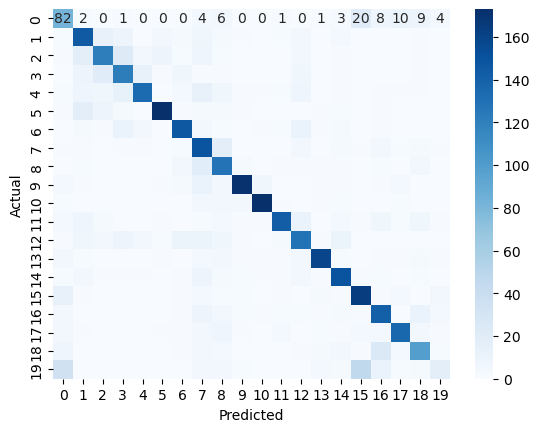

              precision    recall  f1-score   support

           0       0.47      0.54      0.50       151
           1       0.63      0.72      0.67       202
           2       0.67      0.62      0.64       195
           3       0.63      0.67      0.65       183
           4       0.81      0.65      0.72       205
           5       0.89      0.80      0.84       215
           6       0.78      0.76      0.77       193
           7       0.53      0.77      0.63       196
           8       0.57      0.76      0.65       168
           9       0.88      0.81      0.84       211
          10       0.93      0.87      0.90       198
          11       0.87      0.71      0.78       201
          12       0.65      0.64      0.64       202
          13       0.88      0.82      0.85       194
          14       0.74      0.79      0.77       189
          15       0.69      0.81      0.74       202
          16       0.66      0.75      0.70       188
          17       0.81    

In [81]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = grid_search.best_estimator_.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))
